# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [2]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [3]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()



In [4]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav
waves_yesno/1_1_0_0_1_1_1_0.wav
waves_yesno/0_0_1_1_0_1_1_1.wav
waves_yesno/1_1_0_1_0_1_1_0.wav
waves_yesno/0_1_0_0_0_1_1_0.wav
waves_yesno/0_0_0_1_0_0_0_1.wav
waves_yesno/0_0_1_0_1_0_1_1.wav
waves_yesno/0_0_1_0_0_0_1_0.wav
waves_yesno/1_1_0_1_1_0_0_1.wav
waves_yesno/0_1_1_1_0_1_0_1.wav
waves_yesno/0_1_1_1_0_0_0_0.wav
waves_yesno/README~
waves_yesno/0_1_0_0_0_1_0_0.wav
waves_yesno/1_0_0_0_0_0_0_1.wav
waves_yesno/1_1_0_1_1_0_1_1.wav
waves_yesno/1_1_0_0_0_0_0_1.wav
waves_yesno/1_0_0_0_0_0_0_0.wav
waves_y

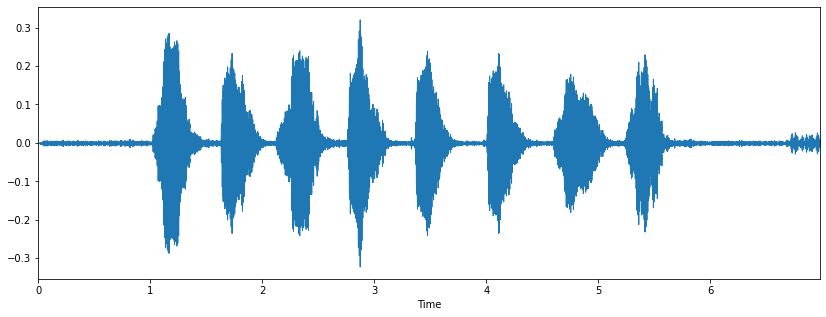

In [5]:
# Загрузим один из файлов
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

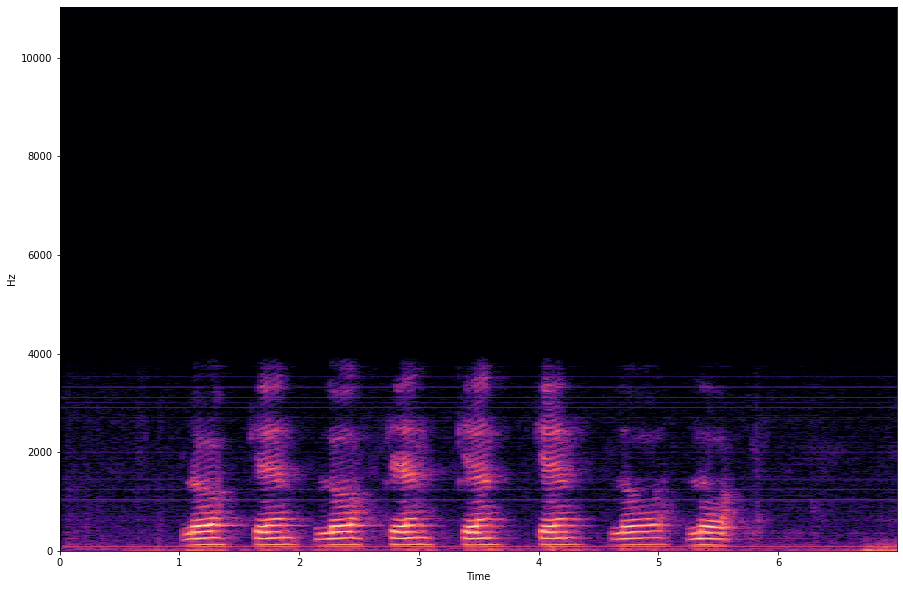

In [6]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

1. В диапозоне 3000 Гц - 4000 Гц признаком является затухание энергии при произнесение "no" и подъем энергии при произнесение "yes"
2. Основная энергия речевого сигнала находится в диапозоне 500 Гц - 2000 Гц

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [7]:
def mel(spec):
    spec = 2595 * np.log10(1 + spec/700)
    return spec

In [9]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("All OK!")
test_mel()

All OK!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [16]:
def mel_filters(sr, n_fft, n_mels):
    f_min = 0
    f_max = sr / 2
    n_mels = int(n_mels)
    mel_matrix = np.zeros((n_mels, 1 + n_fft // 2), dtype=np.float32)
    #fftfreqs = np.fft.rfftfreq(n=n_fft, d=1.0/sr)

    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]

    
    #
    
    #
    return mel_matrix

In [17]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40))
print("All ok!")

AssertionError: 

In [ ]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    
    # YOUR CODE HERE
        
    #
    raise NotImplementedError

In [ ]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_fbank(wav, sr) == 0 , "All wav test failed"
print("All ok!")

In [ ]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 4 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [ ]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
      # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    # YOUR CODE HERE
   
    #
    raise NotImplementedError()

In [ ]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

In [ ]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [ ]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

In [ ]:
# YOUR CODE HERE

# train_VA = # List[np.ndarray]. 1 - Voice, 0 - silence
# test_VA = # List[np.ndarray]. 1 - Voice, 0 - silence
        
#
    

In [ ]:
def test_VAD(VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test) 
print("VAD ok!")

# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95